## Libraries

In [1]:
import cooler

from cooltools import insulation
import cooltools

import numpy as np
import pandas as pd

import bioframe

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

from itertools import combinations
import tqdm

import tad_common
import warnings
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


## Get Bundaries

In [2]:
NPROC = 8
resolution = 10000
windows = [50*resolution]

sample_names = {'Control' : 0, '12min': 12, '30min': 30, '60min': 60}

In [3]:
clr_ = [cooler.Cooler(f"/home/carlos/Desktop/manuscripts/notebooks/matrices/t{sample}_q30.mcool::resolutions/{resolution}") for sample in sample_names.values()]
insulation_table_ = [
    insulation(clr, 
    windows, 
    verbose=False, 
    nproc = NPROC) 
    for clr in clr_
    ]

## Set diff. boundaries

In [4]:
accepted_range = 1
only_strong_base = True
combs_df = tad_common.boundary_switch(
    ins_df_list = insulation_table_, 
    sample_names = list(sample_names.keys()),
    window = windows[0], 
    only_strong_base = only_strong_base, 
    accepted_range = accepted_range)

Processing Control and 12min
Sample1 index: 0, Sample2 index: 1
Total #bins to process of Control: 3721
Processing 30min and 60min
Sample1 index: 2, Sample2 index: 3
Total #bins to process of 30min: 3694
Processing 30min and 12min
Sample1 index: 2, Sample2 index: 1
Total #bins to process of 30min: 3694
Processing 12min and Control
Sample1 index: 1, Sample2 index: 0
Total #bins to process of 12min: 3718
Processing 12min and 60min
Sample1 index: 1, Sample2 index: 3
Total #bins to process of 12min: 3718
Processing 60min and 30min
Sample1 index: 3, Sample2 index: 2
Total #bins to process of 60min: 3653
Processing Control and 30min
Sample1 index: 0, Sample2 index: 2
Total #bins to process of Control: 3721
Processing 60min and 12min
Sample1 index: 3, Sample2 index: 1
Total #bins to process of 60min: 3653
Processing 60min and Control
Sample1 index: 3, Sample2 index: 0
Total #bins to process of 60min: 3653
Processing 12min and 30min
Sample1 index: 1, Sample2 index: 2
Total #bins to process of 

In [6]:
combs_df.to_csv(f"boundary_switch_{accepted_range}_{only_strong_base}.tsv", index=False, sep="\t")

## Viz

In [ ]:
plt.style.use('default')

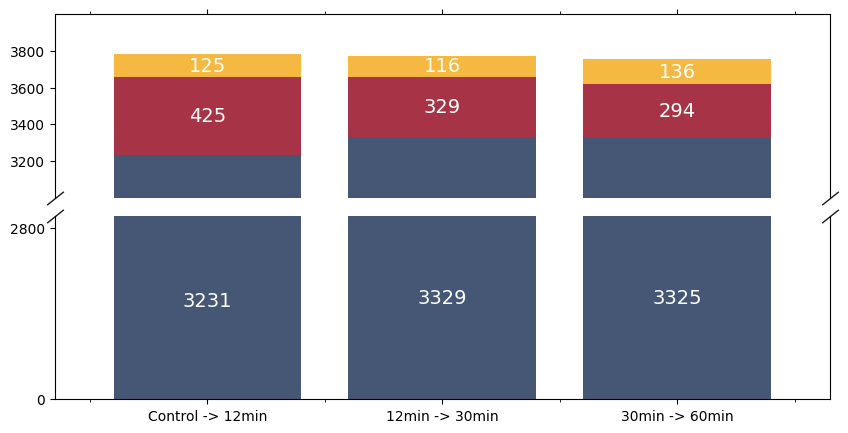

In [ ]:
test_comb =[('Control', '12min'),  ('12min', '30min'), ('30min', '60min')]
test_df = combs_df.copy()
test_df.loc[test_df['case'] == 'Shifted', 'case'] = 'Preserved'
test_df = test_df[test_df.apply(lambda x: (x['sample1'], x['sample2']) in test_comb, axis=1)]

test_df_pr_sh_merged = test_df.copy()
group_df = test_df_pr_sh_merged.groupby(['sample1', 'sample2', 'case']).size().reset_index(name='counts')
group_df['Transitions'] = group_df['sample1'] + ' -> ' + group_df['sample2']
group_df['Transitions'] = group_df['sample1'] + ' -> ' + group_df['sample2']

group_df['Transitions'] = pd.Categorical(group_df['Transitions'], ['Control -> 12min', '12min -> 30min', '30min -> 60min'])
group_df = group_df.sort_values('Transitions')

group_df = group_df.pivot(index=['sample1', 'sample2'], columns='case', values='counts').reset_index()
group_df.index = [f'{sample1} -> {sample2}' for sample1, sample2 in zip(group_df['sample1'], group_df['sample2'])]
group_df = group_df[['Preserved', 'Lost', 'Re-arranged']]

group_df.index = pd.CategoricalIndex(group_df.index, categories=['Control -> 12min', '12min -> 30min', '30min -> 60min'])
group_df = group_df.sort_index()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5), gridspec_kw={'hspace': .1})
group_df.plot(kind='bar', stacked=True, color=["#465775", "#A63446", "#F5B841"], ax = ax1, legend=False, width=.8, align='center')
group_df.plot(kind='bar', stacked=True, color=["#465775", "#A63446", "#F5B841"], ax = ax2, legend=False, width=.8, align='center')

ax1.set_ylim(3000, 4000)  # outliers only
ax2.set_ylim(0, 3000)  # most of the data


ax1.set_yticks([3200., 3400., 3600., 3800.])
ax2.set_yticks([0., 2800.])


ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

d = .8  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

for tick_idx in range(3):
    x_pos = tick_idx
    y_pos = 0
    for state in ['Preserved', 'Lost', 'Re-arranged']:
        count = group_df.loc[group_df.index[tick_idx], state]
        y_pos += count
        if y_pos > 0 and state == 'Preserved':
            ax2.text(x_pos, y_pos/2, count, ha='center', va='center', rotation=0, fontsize=14, color='#FDFFFC')
        else:
            ax1.text(x_pos, y_pos - count/2, count, ha='center', va='center', rotation=0, fontsize=14, color='#FDFFFC')


fig.savefig(f'state_switch.svg', bbox_inches='tight')

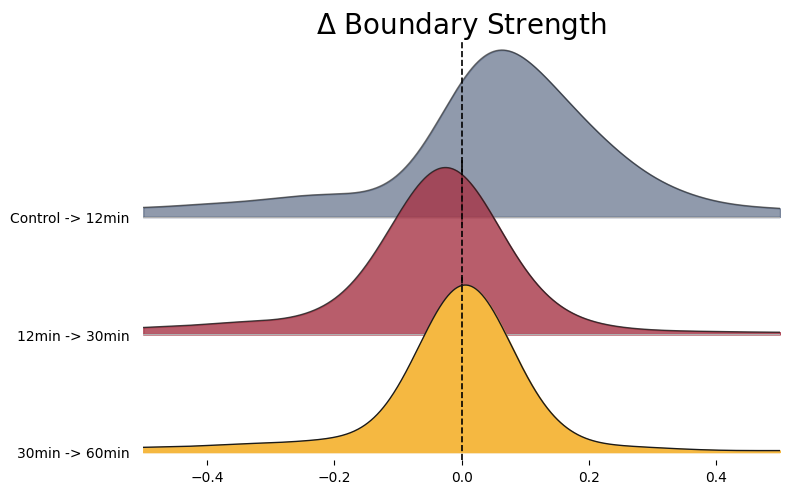

In [ ]:
from joypy import joyplot

plot_DF['comb'] = pd.Categorical(plot_DF['comb'], ['Control -> 12min', '12min -> 30min', '30min -> 60min' ])

from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#A63446", "#F5B841", "#9DBBAE"], N=3)
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#465775", "#A63446", "#F5B841"], N=3)


j = joyplot(plot_DF, by="comb", column="bs_change", figsize=(8, 5), fade=True, colormap=cmp, x_range=[-0.5, 0.5], ylim = 'own',
    grid="y", linewidth=1, legend=False, overlap=1, bins=50, title='$Δ$ Boundary Strength')

for ax in j[1][:3]:
    ax.set_xlabel('')
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, 0, 0.5])
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2)
    ax.set_ylabel('')
    ax.set_title('')
j[1][3].set_title('$Δ$ Boundary Strength', fontsize=20)

plt.savefig(f'delta_boundary_strength.svg', bbox_inches='tight')

In [ ]:
from statannotations.Annotator import Annotator


plot_DF = combs_df.copy()
plot_DF = plot_DF.drop_duplicates(subset=['sample1', 'idx1'])
plot_DF['sample1'] = pd.Categorical(plot_DF['sample1'], ['Control', '12min', '30min', '60min'])
plot_DF.to_csv('boundary_strength_raincloud.tsv', index=False, sep='\t')